In [1]:
!pip3 install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

!pip install matplotlib

!pip install beautifulsoup4

!pip install lxml

!pip install opencv-python

!pip3 install albumentations

!pip install --upgrade albumentations

^C
^C
^C
^C


In [1]:
import shutil
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import os

from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch

import time
from tqdm import tqdm

In [2]:
def generate_box(obj):
    xtl=float(obj['xtl'])
    ytl=float(obj['ytl'])
    xbr=float(obj['xbr'])
    ybr=float(obj['ybr'])
    
    return [xtl,ytl,xbr,ybr]

In [3]:
def generate_label(obj):
    if obj['occluded']=="0":
        return 0
    elif obj['occluded']=="1":
        return 1
    

In [4]:
def generate_target(img_path):
    img_name=img_path[-17:]
    xml_path=glob.glob(img_path[:-17]+"*.xml")
    xml_file=xml_path[0]
    
    f=open(xml_file,'rt',encoding='UTF-8')
    soup=BeautifulSoup(f,"lxml")
    
    img_tag=soup.find("image",{"name":img_name})
    bicycle_tag=img_tag.find_all("box",{"label":"bicycle"})
    boxes=[]
    labels=[]
    
    for i in bicycle_tag:
        boxes.append(generate_box(i))
        labels.append(generate_label(i))
        
    boxes=torch.as_tensor(boxes,dtype=torch.float32)
    labels=torch.as_tensor(labels,dtype=torch.int64)
    
    target={}
    target["boxes"]=boxes
    target["labels"]=labels
    
    return target


In [5]:
def plot_image(img,annotation):
    img=img.permute(1,2,0)
    
    fig,ax=plt.subplots(1)
    #rects=[]
    ax.imshow(img)
    for idx in range(len(annotation["boxes"])):
        xtl,ytl,xbr,ybr=annotation["boxes"][idx]
        
        if annotation["labels"][idx]==0:
            rect=patches.Rectangle((xtl,ytl),(xbr-xtl),(ybr-ytl),linewidth=2,edgecolor='g',facecolor='none')
        else: #annotation["labels"]==1
            rect=patches.Rectangle((xtl,ytl),(xbr-xtl),(ybr-ytl),linewidth=2,edgecolor='r',facecolor='none')
        
        ax.add_patch(rect)
    
        #rects.append(rect)
    
    #return img,rects
    plt.show()         
    

In [6]:
#xml 주소 리스트 반환
def xml_list(start,end): #start~end 폴더 번호
    s=r'G:/walking_video/bounding_box/Bbox_'
    xml_list=[]
    for i in range(start,end+1):
        path=s+str(i).zfill(4)+"/*.xml"
        file=glob.glob(path)
        xml_list.append(file[0]) #경로당 xml파일 1개이기때문
    
    return xml_list

In [7]:
#해당 객체 있는 bicycle 이미지 주소 반환
def img_list(xml_list):
    
    imgs=[]
    for xml in xml_list:
        f=open(xml,'rt',encoding='UTF-8')
        soup=BeautifulSoup(f,"lxml")
        object_list=soup.find_all("box",{"label":"bicycle"})
        
        for i in range(len(object_list)):
            #경로에 따라 슬라이싱 재조정 필요
            path=xml[:40]+(object_list[i].parent)["name"]
            #imgs.append(object_list[i].parent)
            imgs.append(path)
        
        f.close()
            
    imgs=list(set(imgs)) #set으로 중복 제거후 list로 다시 형 변환

    
    return imgs
    

In [8]:
class AlbumentationDataset(Dataset):
    def __init__(self,img_list,transform=None):
        #img_list: 이미지 경로명 리스트
        self.imgs=img_list
        self.transform=transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        img_path=self.imgs[idx]
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        target=generate_target(img_path)
        
        #albumentation
        if self.transform:
            transformed=self.transform(image=image,bboxes=target['boxes'],labels=target['labels'])
            image=transformed['image']
            target={'boxes':transformed['bboxes'],'labels':transformed['labels']}
            
        target['boxes']=torch.as_tensor(target['boxes'],dtype=torch.float32)
        target['labels']=torch.as_tensor(target['labels'],dtype=torch.int64)
        

        #normalize
        image=image.float()
        image=image/255
        return image,target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
albumentations_transform=albumentations.Compose([
    #albumentations.Resize(300,300),
    albumentations.RandomSizedBBoxSafeCrop(width=300,height=300,erosion_rate=0.1),
    #albumentations.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
    #albumentations.Rotate(p=1),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc',label_fields=['labels']),
)

['G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000053.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000160.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000188.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000064.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000150.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000140.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000080.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000189.jpg', 'G:/walking_video/bounding_box/Bbox_0001\\MP_SEL_000142.jpg']
torch.Size([3, 300, 300])
torch.FloatTensor
tensor([[[0.8431, 0.8392, 0.8275,  ..., 0.8667, 0.8667, 0.8588],
         [0.8627, 0.8549, 0.8392,  ..., 0.8667, 0.8667, 0.8588],
         [0.8510, 0.8588, 0.8471,  ..., 0.8627, 0.8627, 0.8588],
         ...,
         [0.7804, 0.7843, 0.7686,  ..., 0.6353, 0.6510, 0.6667],
         [0.7059, 0.6706, 0.6549,  ..., 0.7216, 0.7490, 0.7216],
         [0.6510, 0.6510, 0.6431,  ..., 0.7725, 0.7922, 0.

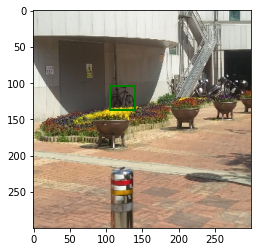

In [31]:
#albumentation test
xml=xml_list(1,1)
imgs=img_list(xml)
print(imgs)
albumentation_dataset=AlbumentationDataset(img_list=imgs,transform=albumentations_transform)

img,annot=albumentation_dataset[4]
print(img.size())
print(img.type())
print(img)
print(annot)
plot_image(img,annot)

In [ ]:
# type test
print(type(img))


In [ ]:
from collections import Counter

def get_num_objects_for_each_class(dataset):
    
    total_labels=[]
    for img,annot in tqdm(dataset,position=0,leave=True):
        total_labels+=[int(i) for i in annot['labels']]
        
    return Counter(total_labels)

In [10]:
def zero_box_check(dataset):
    
    zero_torch=torch.randn(0)
    img_idx=[]
    index=0
    for img,annot in dataset:
        box=annot['boxes']
        if box.size()==zero_torch.shape:
            #print(img)
            #print(annot)
            #plot_image(img,annot)
            img_idx.append(index)
    
        index+=1
        
    return img_idx
        

In [11]:
data_xml_list=xml_list(1,300)
data_img_list=img_list(data_xml_list)

In [ ]:
#img path check
for img in tqdm(data_img_list):
    if not os.path.isfile(img):
        print(img)
        
    

In [12]:
dataset=AlbumentationDataset(img_list=data_img_list,transform=albumentations_transform)
data_loader=torch.utils.data.DataLoader(dataset,batch_size=8, collate_fn=collate_fn)

In [ ]:
#box data check
zero_index=zero_box_check(dataset)
for idx in zero_index:
    print(data_img_list[idx])
 

In [16]:
train_objects=get_num_objects_for_each_class(dataset)
print(train_objects)

100%|██████████████████████████████████████████████████████████████████████████████| 7215/7215 [13:22<00:00,  8.99it/s]

Counter({1: 7054, 0: 3978})


In [14]:
retina=torchvision.models.detection.retinanet_resnet50_fpn(num_classes=1,pretrained=False,pretrained_backbone=True)


In [34]:
#torch.cuda.is_available()
torch.cuda.empty_cache()

In [14]:
torch.cuda.empty_cache()
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs=100
learning_rate=0.001
retina.to(device)

params=[p for p in retina.parameters() if p.requires_grad]
optimizer=torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

len_dataloader=len(data_loader)


for epoch in range(num_epochs):
    start=time.time()
    retina.train()
    
    zero=0
    i=0
    epoch_loss=0
    for images, targets in tqdm(data_loader):
        images=list(image.to(device) for image in images)
        targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
        
        #print(targets)
    
        #ignore zero target
        zero_torch=torch.randn(0)
        if targets[0]['boxes'].size()==zero_torch.shape:
            zero+=1
            continue
        
        loss_dict=retina(images,targets)
        
        losses=sum(loss for loss in loss_dict.values())
        
        i+=1
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss+=losses
        
    print(epoch,epoch_loss,f'time: {time.time()-start}')
        

  0%|                                                                                          | 0/902 [00:00<?, ?it/s]C:\Users\SeongJin\anaconda3\envs\capstone\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:58<00:00,  1.13s/it]


0 tensor(1220.4576, device='cuda:0', grad_fn=<AddBackward0>) time: 1018.5726096630096


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:51<00:00,  1.12s/it]


1 tensor(837.1962, device='cuda:0', grad_fn=<AddBackward0>) time: 1011.6122512817383


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:47<00:00,  1.12s/it]


2 tensor(743.5483, device='cuda:0', grad_fn=<AddBackward0>) time: 1007.5946116447449


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:40<00:00,  1.11s/it]


3 tensor(706.1119, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.0147683620453


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:40<00:00,  1.11s/it]


4 tensor(666.9321, device='cuda:0', grad_fn=<AddBackward0>) time: 1000.6459901332855


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


5 tensor(653.2440, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.4747731685638


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


6 tensor(648.3578, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.8463144302368


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


7 tensor(606.1423, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.7116496562958


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


8 tensor(586.1866, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8556160926819


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


9 tensor(580.5571, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.4081149101257


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


10 tensor(569.7542, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.4736943244934


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


11 tensor(551.3857, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.0403990745544


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


12 tensor(546.1248, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.9997844696045


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


13 tensor(540.4808, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.6510009765625


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


14 tensor(530.0920, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.1472208499908


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


15 tensor(520.2557, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.2694883346558


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


16 tensor(509.6751, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.4945554733276


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:47<00:00,  1.12s/it]


17 tensor(505.5773, device='cuda:0', grad_fn=<AddBackward0>) time: 1007.6788003444672


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


18 tensor(496.6251, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.6163847446442


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


19 tensor(496.6561, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.2529702186584


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


20 tensor(483.8684, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.5293769836426


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


21 tensor(477.7658, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8297100067139


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


22 tensor(472.7289, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.6513824462891


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


23 tensor(473.3178, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.1341228485107


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:46<00:00,  1.12s/it]


24 tensor(467.1088, device='cuda:0', grad_fn=<AddBackward0>) time: 1006.2447655200958


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


25 tensor(458.1779, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.1112020015717


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


26 tensor(458.3456, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.0478496551514


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


27 tensor(452.6883, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.2474756240845


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


28 tensor(449.6777, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.9287655353546


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


29 tensor(437.3692, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8129994869232


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


30 tensor(438.2009, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8481059074402


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


31 tensor(438.6370, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.8775656223297


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


32 tensor(430.7212, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.5796811580658


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


33 tensor(429.7380, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.445876121521


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


34 tensor(425.3966, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.1626980304718


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


35 tensor(423.1661, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.502519607544


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


36 tensor(423.3365, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.0836186408997


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


37 tensor(421.7058, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.3378708362579


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


38 tensor(412.0952, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.6674513816833


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


39 tensor(408.5275, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.5194578170776


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


40 tensor(405.6424, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.3369703292847


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


41 tensor(406.9791, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.3294277191162


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


42 tensor(399.9196, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.5621201992035


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


43 tensor(398.6514, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.4532554149628


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


44 tensor(394.9096, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.339950799942


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:54<00:00,  1.12s/it]


45 tensor(393.8340, device='cuda:0', grad_fn=<AddBackward0>) time: 1014.5692331790924


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:55<00:00,  1.13s/it]


46 tensor(388.9651, device='cuda:0', grad_fn=<AddBackward0>) time: 1015.6026773452759


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


47 tensor(389.4473, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.6626167297363


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


48 tensor(386.2100, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.4876036643982


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


49 tensor(383.9817, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.7299582958221


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


50 tensor(381.2186, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.4892017841339


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


51 tensor(381.9403, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.4726011753082


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:54<00:00,  1.12s/it]


52 tensor(374.0433, device='cuda:0', grad_fn=<AddBackward0>) time: 1014.5405333042145


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:50<00:00,  1.12s/it]


53 tensor(374.8793, device='cuda:0', grad_fn=<AddBackward0>) time: 1010.2689476013184


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


54 tensor(369.6018, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.8754980564117


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


55 tensor(370.3784, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.6445460319519


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


56 tensor(371.1001, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.3648116588593


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:45<00:00,  1.11s/it]


57 tensor(366.6928, device='cuda:0', grad_fn=<AddBackward0>) time: 1005.5477442741394


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


58 tensor(362.8788, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.3379888534546


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [17:02<00:00,  1.13s/it]


59 tensor(363.7019, device='cuda:0', grad_fn=<AddBackward0>) time: 1022.9208652973175


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


60 tensor(356.1074, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.3031461238861


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


61 tensor(364.3381, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.4426155090332


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


62 tensor(358.0913, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.13623046875


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


63 tensor(353.4533, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.1380450725555


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


64 tensor(353.0105, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.2731642723083


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


65 tensor(355.3685, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.3518631458282


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


66 tensor(349.4800, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.3231227397919


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


67 tensor(348.3738, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.3925821781158


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


68 tensor(341.7214, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.4584295749664


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


69 tensor(349.2378, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8635103702545


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


70 tensor(348.8035, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.5091853141785


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


71 tensor(339.5737, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.3032248020172


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


72 tensor(338.4918, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.8345997333527


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


73 tensor(335.6224, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.7988896369934


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


74 tensor(341.9813, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.4539518356323


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


75 tensor(345.9661, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.8432676792145


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


76 tensor(331.3622, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.1585693359375


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


77 tensor(328.8227, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.7957587242126


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


78 tensor(329.5493, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.8754425048828


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


79 tensor(328.7194, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.1860463619232


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


80 tensor(353.3932, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.5589780807495


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


81 tensor(325.7526, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.0201015472412


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


82 tensor(323.5569, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.9319252967834


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


83 tensor(335.9489, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.7485430240631


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


84 tensor(322.8110, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.2744045257568


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


85 tensor(318.1128, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.2831258773804


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


86 tensor(320.3938, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.3509910106659


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


87 tensor(319.3783, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.5156321525574


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


88 tensor(321.0162, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.2728545665741


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:40<00:00,  1.11s/it]


89 tensor(309.8723, device='cuda:0', grad_fn=<AddBackward0>) time: 1000.6647770404816


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


90 tensor(316.8868, device='cuda:0', grad_fn=<AddBackward0>) time: 1001.2161695957184


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


91 tensor(311.7030, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.2787661552429


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


92 tensor(309.6177, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.8982696533203


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:41<00:00,  1.11s/it]


93 tensor(306.6554, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.0390899181366


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


94 tensor(313.0009, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.901346206665


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


95 tensor(301.4178, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.7617225646973


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:44<00:00,  1.11s/it]


96 tensor(306.9067, device='cuda:0', grad_fn=<AddBackward0>) time: 1004.8499994277954


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


97 tensor(306.4856, device='cuda:0', grad_fn=<AddBackward0>) time: 1002.1612238883972


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:42<00:00,  1.11s/it]


98 tensor(302.5596, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.0683786869049


100%|████████████████████████████████████████████████████████████████████████████████| 902/902 [16:43<00:00,  1.11s/it]


99 tensor(302.7413, device='cuda:0', grad_fn=<AddBackward0>) time: 1003.3531684875488


In [15]:
torch.save(retina.state_dict(),f'retina_{num_epochs}_{learning_rate}.pt')

In [15]:
#retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))
retina.load_state_dict(torch.load(f'retina_30_0.001_OID.pt'))
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [16]:
def make_prediction(model,img,threshold):
    model.eval()
    preds=model(img)
    for id in range(len(preds)):
        idx_list=[]
        
        for idx,score in enumerate(preds[id]['scores']):
            if score>threshold:
                idx_list.append(idx)
                
        preds[id]['boxes']=preds[id]['boxes'][idx_list]
        preds[id]['labels']=preds[id]['labels'][idx_list]
        preds[id]['scores']=preds[id]['scores'][idx_list]
        
        
    return preds


In [17]:
test_data_xml_list=xml_list(301,410)
test_data_img_list=img_list(test_data_xml_list)

In [18]:
test_dataset=AlbumentationDataset(img_list=test_data_img_list,transform=albumentations_transform)
test_data_loader=torch.utils.data.DataLoader(test_dataset,batch_size=8, collate_fn=collate_fn)

In [ ]:
labels=[]
preds_adj_all=[]
annot_all=[]

for im,annot in tqdm(test_data_loader,position=0,leave=True):
    im=list(img.to(device) for img in im)
    
    for t in annot:
        labels+=t['labels']
        
    with torch.no_grad():
        preds_adj=make_prediction(retina,im,0.5)
        preds_adj=[{k:v.to(torch.device('cpu')) for k,v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

  0%|                                                                                          | 0/441 [00:00<?, ?it/s]C:\Users\SeongJin\anaconda3\envs\capstone\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 95%|███████████████████████████████████████████████████████████████████████████▋    | 417/441 [09:38<00:33,  1.38s/it]

In [ ]:
import random

total=range(len(test_data_loader))
select=random.sample(total,10);

for i in select:
    test_annot=annot_all[i][0]
    img,annot=test_dataset[i]

    plot_image(img,annot)
    plot_image(img,test_annot)

In [ ]:
import utils_ObjectDetection as utils

In [ ]:
sample_metrics=[]
for batch_i in range(len(preds_adj_all)):
    sample_metrics+=utils.get_batch_statistics(preds_adj_all[batch_i],annot_all[batch_i],iou_threshold=0.5)
    
true_positives,pred_scores,pred_labels=[torch.cat(x,0) for x in list(zip(*sample_metrics))]
precision,recall,AP,f1,ap_class=utils.ap_per_class(true_positives,pred_scores,pred_labels,torch.tensor(labels))
mAP=torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')